# model.ipynb

A more organised notebook that runs the model

Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

# Model Parameters

In [2]:
# # Birds
v0 = 1.0      # velocity of birds (constant)
eta = 0.5      # maximum random fluctuation in angle (in radians)
R_bird = 1        # interaction radius (bird-bird)
Rsq = R_bird**2     # square of the interaction radius
N = 144   # number of birds


# # Time parameters
dt = 0.2      # time step
Nt = 80       # number of time steps

# # Area parameters
L = 10       # size of box (Area of a real wind farm)


# # Obstacles
R_obs = 0.5 # interaction radius (bird - obstacles)
fov_angle = np.pi # Field of View of birds


# # Wind
v0_wind = 0.2 # velocity of wind (constant)
v_wind_noise = 0.05 # maximum random fluctuation in wind velocity (in same units as v0_wind)
wind_theta = 0 # wind direction 


#np.random.seed(17)      # set the random number generator seed

# Starting position

In [3]:
def add_noise_theta(theta, eta, N):
    '''
    Update theta with a random amount of noise between -eta/2 and eta/2
    '''
    theta += eta * (np.random.rand(N, 1) - 0.5)
    
    return theta

In [4]:
def initialize_birds_random(N, L, v0):
    '''
    Set initial positions, direction, and velocities 
    '''
    # Bird positions
    x = np.random.rand(N, 1)*L
    y = np.random.rand(N, 1)*L

    # Bird velocities
    theta = 2 * np.pi * np.random.rand(N, 1)
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    return x, y, vx, vy, theta

In [5]:
def initialize_birds_uniform(N, L, v0, theta_start, eta):
    '''
    Set initial positions as a uniform placement starting at the edge of the box.
    Set direction and velocity to be uniform with a small amount of noise 
    '''
    
    # Set bird initial flock as a square
    N_per_side = int(np.sqrt(N))
    
    # Midpoint of area 
    midpoint = L//2
    
    # Define the x locations (start in centre of perimeter)
    half_length = N_per_side // 2
    start = midpoint - half_length
    x_locs = np.arange(start, start + N_per_side)
    
    # Define the y locations (start from bottom)
    y_locs = np.arange(0, N_per_side)
    
    # Define bird starting points
    # Initialise lists
    x = []
    y = []
    
    for x_loc in x_locs:
        for y_loc in y_locs:
            x.append([x_loc])
            y.append([y_loc])
    
    # Turn into numpy arrays
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    
    # Bird Angle
    # Make all birds same starting angle
    theta = np.ones((len(x),1))*theta_start
    
    # Add noise
    theta = add_noise_theta(theta, eta, N)
    
    
    # Bird velocities
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)
    
    
    return x, y, vx, vy, theta

# Obstacles

### Functions

In [35]:
def make_circular_obstacle(x_centre, y_centre, R, n=20):
    '''
    Returns x,y points defining a circular obstacle
    '''
    angles = np.linspace(0, 2 * np.pi, n)
    
    x = x_centre + R*np.cos(angles)
    y = y_centre + R*np.sin(angles)
    
    return x, y


def make_rectangular_obstacle(x_centre, y_centre, L1, L2, n=25):
    '''
    Returns x,y points defining a rectangular obstacle
    '''
    
    # Number of points per side
    points_per_side = n // 4
    
    # Half lengths for width and height
    l1 = L1 / 2
    l2 = L2 / 2
    
    # Corners of the rectangle
    top_left = [x_centre - l1, y_centre + l2]
    top_right = [x_centre + l1, y_centre + l2]
    bottom_left = [x_centre - l1, y_centre - l2]
    bottom_right = [x_centre + l1, y_centre - l2]
    
    # Initialize lists for x and y points
    x_points = []
    y_points = []
    
    # Generate points along each side
    # Top edge (left to right)
    x_points.extend(np.linspace(top_left[0], top_right[0], points_per_side))
    y_points.extend([top_left[1]] * points_per_side)
    
    # Right edge (top to bottom)
    x_points.extend([top_right[0]] * points_per_side)
    y_points.extend(np.linspace(top_right[1], bottom_right[1], points_per_side))
    
    # Bottom edge (right to left)
    x_points.extend(np.linspace(bottom_right[0], bottom_left[0], points_per_side))
    y_points.extend([bottom_left[1]] * points_per_side)
    
    # Left edge (bottom to top)
    x_points.extend([bottom_left[0]] * points_per_side)
    y_points.extend(np.linspace(bottom_left[1], top_left[1], points_per_side))
    
    return x_points, y_points

def get_obstacle_centre_grid(L, num_obstacles, nrows, ncols):
    '''
    Define the centre of obstacles based on a grid.
    '''
    x_spacing = L / (ncols + 1)
    y_spacing = L / (nrows + 1)
    
    x_centres = []
    y_centres = []

    # Calc grid positions
    cnt = 0
    for i in range(nrows):
        for j in range(ncols):
            if cnt > num_obstacles:
                break
        
            # Calculate centre positions
            x_centre = (j + 1) * x_spacing
            y_centre = (i + 1) * y_spacing
            x_centres.append(x_centre)
            y_centres.append(y_centre)
            cnt += 1
    
    return x_centres, y_centres

def get_obstacles(L, num_obstacles, nrows, ncols):
    '''
    Call the obstacle functions and get lists of their x, y points
    '''
    
    x_centres, y_centres = get_obstacle_centre_grid(L, num_obstacles, nrows=nrows, ncols=ncols)
    
    # Initalise lists
    x_obstacle_list = []
    y_obstacle_list = []
    
    for i in range(num_obstacles):
        # Make circular obstacles
        x_obs, y_obs = make_circular_obstacle(x_centres[i], y_centres[i], R=0.25, n=20)
        
        # Make rectangular obstacles
        # x_obs, y_obs = make_rectangular_obstacle(x_centres[i], y_centres[i], L1=1, L2=0.2, n=25)
        
        x_obstacle_list.append(x_obs)
        y_obstacle_list.append(y_obs)
    
    # Concatenate lists for analysis
    x_obstacle = np.concatenate(x_obstacle_list)
    y_obstacle = np.concatenate(y_obstacle_list)
    
    return x_obstacle_list, y_obstacle_list, x_obstacle, y_obstacle

### Obstacle parameters

Defined below in the "run simulation" step

# Wind

### Parameters

In [36]:
v0_wind = 0.5 # velocity of wind (constant)
v_wind_noise = 0.1 # maximum random fluctuation in wind velocity (in same units as v0_wind)
wind_theta = 0 # wind direction 

### Functions

In [37]:
def wind_constant_with_noise(v0_wind, v_wind_noise, wind_theta):
    '''
    Returns the x, y components of wind based on a constant angle.
    '''
    # Add random noise to the wind
    v0_wind += v_wind_noise * (np.random.rand(1) - 0.5)[0]

    # Get x, y velocity components
    vx_wind = v0_wind* np.cos(wind_theta)
    vy_wind = v0_wind* np.sin(wind_theta)
    
    return vx_wind, vy_wind

In [38]:
def wind_dynamic(t, v0_wind_base, v_wind_amplitude, v_wind_noise, wind_theta_base, wind_theta_variation, frequency_speed, frequency_direction):
    """
    Simulate wind velocity with a sinusoidal component and noise.
    Args:
        t: Current time step
        v0_wind_base: Base wind speed
        v_wind_amplitude: Amplitude of the sinusoidal variation in wind speed
        v_wind_noise: Maximum random fluctuation in wind speed
        wind_theta_base: Base wind direction (in radians)
        wind_theta_variation: Maximum variation in wind direction
        frequency_speed: Frequency of the sinusoidal wind speed variation
        frequency_direction: Frequency of the sinusoidal wind direction variation
    """
    # Sinusoidal variation in wind speed
    v0_wind = v0_wind_base + v_wind_amplitude * np.sin(2 * np.pi * frequency_speed * t)
    
    # Add random noise to the wind speed
    v0_wind += v_wind_noise * (np.random.rand() - 0.5)
    
    # Gradually change wind direction with sinusoidal variation
    wind_theta = wind_theta_base + wind_theta_variation * np.sin(2 * np.pi * frequency_direction * t)
    
    # Get x, y velocity components of wind
    vx_wind = v0_wind * np.cos(wind_theta)
    vy_wind = v0_wind * np.sin(wind_theta)
    
    return vx_wind, vy_wind


# Updating steps

In [39]:
def apply_boundary_conditions(x, y, L):
    '''
    Apply periodic boundary conditions
    Creates wrap-around effect, if crossing bounary enter other side 
    '''
    x = x % L
    y = y % L
    return x, y

In [40]:
def update_positions(x, y, vx, vy, dt, L):
    '''
    Update the positions moving dt in the direction of the velocity
    and applying the boundary conditions
    '''
    
    # update positions
    x += vx*dt
    y += vy*dt
    
    # apply boundary conditions
    x, y = apply_boundary_conditions(x,y,L)
    return x, y

## Update Angle

In [41]:
def get_mean_theta_neighbours(x, y, theta, Rsq, N):
    '''
    Compute the local average direction in a circle of radius R around
    each bird. If there are no neighbours, simply keep same theta.
    '''
    mean_theta = theta
    for bird in range(N):
        neighbours = (x-x[bird])**2+(y-y[bird])**2 < Rsq
        sum_x = np.sum(np.cos(theta[neighbours]))
        sum_y = np.sum(np.sin(theta[neighbours]))
        mean_theta[bird] = np.arctan2(sum_y, sum_x)
    
    return mean_theta

def get_obstacles_within_radius(x_bird, y_bird, theta_bird, x_obstacle, y_obstacle, R_obs, fov_angle):
    
    # Determine if obstacle is in radius
    distances_to_obstacles = np.sqrt((x_obstacle - x_bird) ** 2 + (y_obstacle - y_bird)**2)
    is_in_radius = distances_to_obstacles <= R_obs
    
    # Select only object in radius
    x_obs_in_radius = x_obstacle[is_in_radius]
    y_obs_in_radius = y_obstacle[is_in_radius]
    distances = distances_to_obstacles[is_in_radius]
    
    # Determine if obstacle is in FOV
    
    # Calculate angle to the obstacle    
    delta_x = x_obs_in_radius - x_bird
    delta_y = y_obs_in_radius - y_bird
    angles_to_obstacles = np.arctan2(delta_y, delta_x)
    
    # Difference between obstacle and current direction of bird
    angle_diff = np.abs(angles_to_obstacles - theta_bird)
    
    # Filter by field of view
    is_in_fov = angle_diff <= fov_angle
    x_obs_in_radius = x_obs_in_radius[is_in_fov]
    y_obs_in_radius = y_obs_in_radius[is_in_fov]
    distances = distances[is_in_fov]
    
    return x_obs_in_radius, y_obs_in_radius, distances


In [42]:
def update_theta(x, y, theta, Rsq, x_obstacle, y_obstacle, R_obs, eta, N, fov_angle):
    '''
    We will do this per bird, since we need to see if each one is within distance of obstacles or not
    
    '''
    # Initialize new theta array
    theta_new = theta.copy()
    
    # Get the mean theta from the neighbours
    mean_theta = get_mean_theta_neighbours(x, y, theta, Rsq, N)
    
    # Update theta based on obstacles
    for i in range(N):
        # Determine if obstacles in radius
        x_obs_in_radius, y_obs_in_radius, distances = get_obstacles_within_radius(x[i], y[i], theta_new[i], x_obstacle, y_obstacle, R_obs, fov_angle)

        # Only continue if there are obstacles in radius
        if np.any(distances):
            # Obstacle avoidance logic in advance, gradually adjusting direction
            avoidance_vectors = np.array([x[i] - x_obs_in_radius, y[i] - y_obs_in_radius])
    
            # Normalise by distance (closer obstacles have more influence)
            avoidance_vectors = avoidance_vectors / distances
    
            # Sum up the avoidance vectors to get the net avoidance direction
            net_avoidance_vector = np.sum(avoidance_vectors, axis=0)
    
            #Avoidance strategy: gradually adjust direction instead of direct opposite
            if net_avoidance_vector.size >= 2:
                # Normalize the net avoidance vector to limit abrupt changes
                net_avoidance_vector /= np.linalg.norm(net_avoidance_vector)
                # Combine with current velocity to smoothly adjust direction
                avoidance_theta = np.arctan2(net_avoidance_vector[1], net_avoidance_vector[0])
                avoidance_weight = 0.5  # Reduce weight for smoother turn
                theta_new[i] = (1 - avoidance_weight) * mean_theta[i] + avoidance_weight * avoidance_theta
            else:
                # Use mean direction if no valid avoidance vector found
                theta_new[i] = mean_theta[i]

        
        # If no obstacle, use theta from neighbours
        else:
            theta_new[i] = mean_theta[i]
        
    
    theta_new = add_noise_theta(theta_new, eta, N)
    
    return theta_new

## Update Velocity

In [43]:
def update_velocities(v0, theta, vx_wind, vy_wind):
    '''
    Update the velocities given theta, assuming a constant speed v0
    '''
    vx = v0 * np.cos(theta) + vx_wind
    vy = v0 * np.sin(theta) + vy_wind

    return vx, vy

## Steps and Update Quiver

In [44]:
def step(x, y, vx, vy, theta, Rsq, x_obstacle, y_obstacle, eta, fov_angle, N, dt, v0_wind, v_wind_noise, wind_theta):
    '''
    Compute a step in the dynamics:
    - update the positions
    - compute the new velocities
    '''
    x, y = update_positions(x, y, vx, vy, dt, L)
    theta = update_theta(x, y, theta, Rsq, x_obstacle, y_obstacle, R_obs, eta, N, fov_angle)
    
    vx_wind, vy_wind = wind_constant_with_noise(v0_wind, v_wind_noise, wind_theta)
    
    vx, vy = update_velocities(v0, theta, vx_wind, vy_wind)
    
    return x, y, vx, vy, vx_wind, vy_wind

def update_quiver(q,x,y,vx,vy):
    '''
    Update a quiver with new position and velocity information
    This is only used for plotting
    '''
    q.set_offsets(np.column_stack([x,y]))
    q.set_UVC(vx,vy)
    
    return q

## Clustering Coefficient

Define the clustering coefficient:

$$
\varphi = \frac{1}{N v_0} \sqrt{\left( \sum_{i=1}^N v_{i,x} \right)^2 + \left( \sum_{i=1}^N v_{i,y} \right)^2}
$$

But we need to consider the addition of wind, so we can't simply use $v_0$.

Instead use
$$
\varphi = \frac{1}{N v_{expected}} \sqrt{\left( \sum_{i=1}^N v_{i,x} \right)^2 + \left( \sum_{i=1}^N v_{i,y} \right)^2}
$$

where,

$$
v_{expected} = \frac{1}{N} \sqrt {v_{i,x}^2 + v_{i,y}^2}
$$

The avaerage bird speed at every time step accounting for the addition of wind.

In [45]:
def get_clustering_coefficient(vx, vy, v0, vx_wind, vy_wind, N):
    
    # Sum the vx and vy components (with wind included)
    sum_terms_x = np.sum(vx)
    sum_terms_y = np.sum(vy)
    sum_terms = np.linalg.norm([sum_terms_x, sum_terms_y])
    
    # Get the expected v, v0 + v_wind
    # Expected total velocity magnitude per bird
    # v_expected = np.sqrt(v0**2 + vx_wind**2 + vy_wind**2) # doesn't work?
    
    # Average bird speed (calculate direc)
    v_expected = np.mean(np.sqrt(vx**2 + vy**2))
    
    # Calculate coefficient
    clustering_coefficient = (1/(N*v_expected))*sum_terms
    
    return clustering_coefficient

# Run Simulation

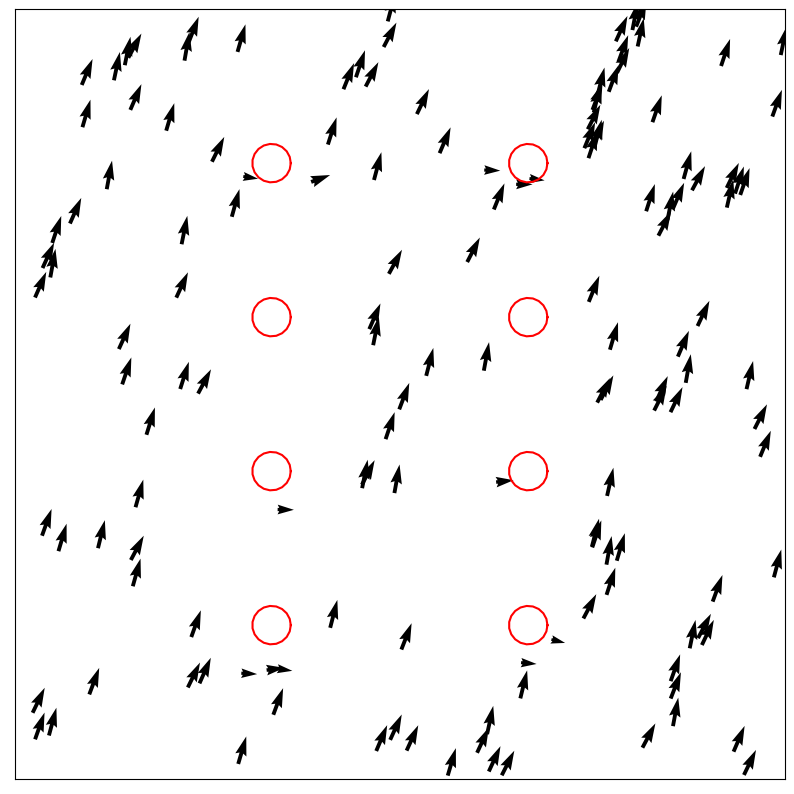

In [46]:
# Set up a figure
fig, ax = plt.subplots(figsize = (10,10))

# Get obstacles
# Number of obstacles
num_obstacles = 8
nrows = 4
ncols = 2

x_obstacle_list, y_obstacle_list, x_obstacle, y_obstacle = get_obstacles(L, num_obstacles, nrows, ncols)

# Plot obstacle(s) - Plot the "list" to visualise the different obstaclces properly
for xx, yy in zip(x_obstacle_list, y_obstacle_list):
    ax.plot(xx, yy, 'r-')

# # Get the initial configuration

# Random
# x, y, vx, vy, theta = initialize_birds_random(N, L, v0)

# Uniform
theta_start = np.pi/3
x, y, vx, vy, theta = initialize_birds_uniform(N, L, v0, theta_start, eta)

# Plot initial quivers
q = plt.quiver(x,y,vx,vy,scale=40)

# Set figure parameters
ax.set(xlim=(0, L), ylim=(0, L))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Initilise lists to plot later
vx_wind_list = []
vy_wind_list = []

clustering_coefficients = []

# Do each step, updating the quiver and plotting the new one
for i in range(Nt):
    # print(i)
    x, y, vx, vy, vx_wind, vy_wind = step(x, y, vx, vy, theta, Rsq, x_obstacle, y_obstacle, eta, fov_angle, N, dt, v0_wind, v_wind_noise, wind_theta=np.pi/2)
    q = update_quiver(q, x, y, vx, vy)
    clear_output(wait=True)
    display(fig)
    # Plot initial quivers

    # Append wind information
    vx_wind_list.append(vx_wind)    
    vy_wind_list.append(vy_wind)
    
    # Append clustering coefficient
    clustering_coefficients.append(get_clustering_coefficient(vx, vy, v0, vx_wind, vy_wind, N))

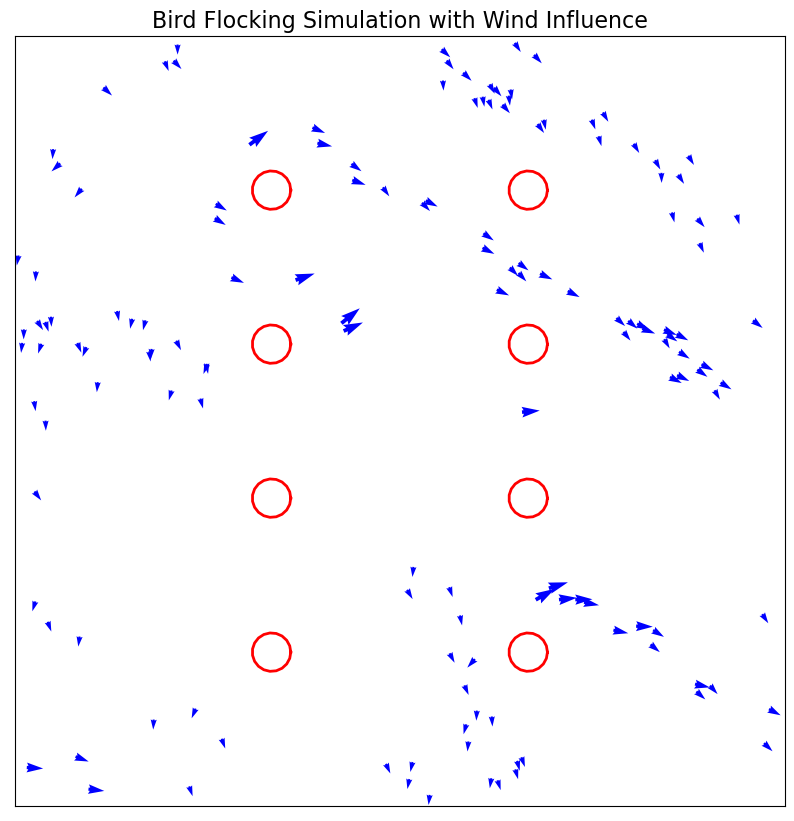

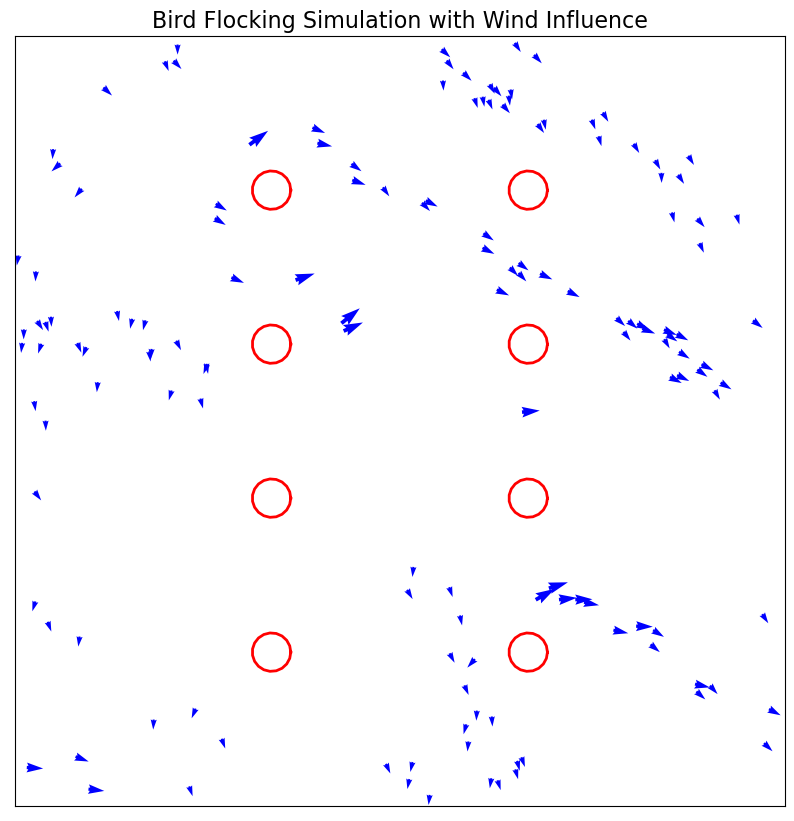

In [50]:
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 10))

# Get obstacles
# Number of obstacles
num_obstacles = 8
nrows = 4
ncols = 2

x_obstacle_list, y_obstacle_list, x_obstacle, y_obstacle = get_obstacles(L, num_obstacles, nrows, ncols)

# Plot obstacles - Plot the "list" to visualize the different obstacles properly
for xx, yy in zip(x_obstacle_list, y_obstacle_list):
    ax.plot(xx, yy, 'r-', linewidth=2)

# Get the initial configuration

# Random
# x, y, vx, vy, theta = initialize_birds_random(N, L, v0)

# Uniform
theta_start = np.pi / 3
x, y, vx, vy, theta = initialize_birds_uniform(N, L, v0, theta_start, eta)

# Plot initial quivers
q = plt.quiver(x, y, vx, vy, scale=40)

# Set figure parameters
ax.set(xlim=(0, L), ylim=(0, L))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Initialize lists to plot later
vx_wind_list = []
vy_wind_list = []

clustering_coefficients = []

# Wind parameters
v0_wind_base = 0.2  # Base wind speed
v_wind_amplitude = 0.1  # Wind speed amplitude

frequency_speed = 0.05  # Frequency of wind speed variation
frequency_direction = 0.01  # Frequency of wind direction variation
wind_theta_base = 0  # Base wind direction (along x-axis)
wind_theta_variation = np.pi / 4  # Maximum variation in wind direction angle

# Perform each step, updating the quiver and plotting the new one
for t in range(Nt):
    # Calculate wind components with dynamic wind model
    vx_wind, vy_wind = wind_dynamic(t * dt, v0_wind_base, v_wind_amplitude, v_wind_noise, wind_theta_base, wind_theta_variation, frequency_speed, frequency_direction)

    # Update bird positions and velocities
    for _ in range(2):  # Adjust directions multiple times within each time step
        theta = update_theta(x, y, theta, Rsq, x_obstacle, y_obstacle, R_obs, eta, N, fov_angle)

    x, y, vx, vy, _, _ = step(x, y, vx, vy, theta, Rsq, x_obstacle, y_obstacle, eta, fov_angle, N, dt, v0_wind, v_wind_noise, wind_theta=np.pi / 2)

    # Plot updated quiver with fixed scale
    ax.clear()
    ax.set_title('Bird Flocking Simulation with Wind Influence', fontsize=16)
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    for xx, yy in zip(x_obstacle_list, y_obstacle_list):
        ax.plot(xx, yy, 'r-', linewidth=2)

    q = plt.quiver(x, y, vx, vy, scale=4, angles='xy', scale_units='xy', color='b', width=0.005)

    clear_output(wait=True)
    display(fig)

    # Append wind information
    vx_wind_list.append(vx_wind)
    vy_wind_list.append(vy_wind)

    # Append clustering coefficient
    clustering_coefficients.append(get_clustering_coefficient(vx, vy, v0, vx_wind, vy_wind, N))

plt.ioff()
plt.show()


# Plot Wind

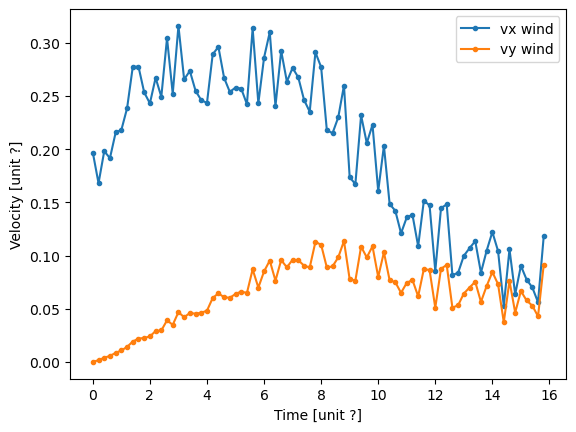

In [32]:
fig, ax = plt.subplots()

time = np.arange(0, Nt * dt, dt)

ax.plot(time, vx_wind_list, '.-', label = 'vx wind')
ax.plot(time, vy_wind_list, '.-', label = 'vy wind')

ax.set_xlabel('Time [unit ?]')
ax.set_ylabel('Velocity [unit ?]')

ax.legend()

plt.show()

# Plot Clustering Coefficient

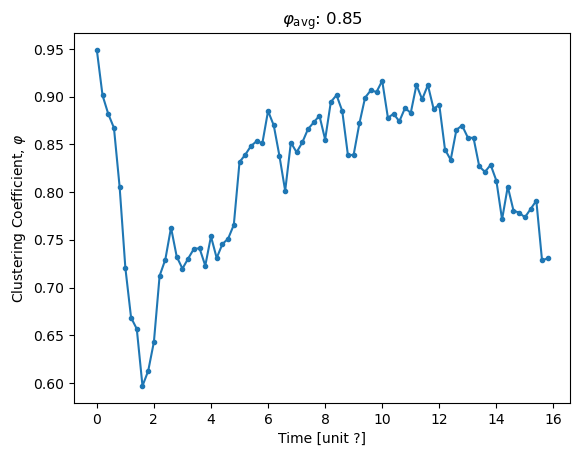

In [25]:
fig, ax = plt.subplots()

time = np.arange(0, Nt * dt, dt)

ax.plot(time, clustering_coefficients, '.-')

# Set figure parameters
ax.set_xlabel('Time [unit ?]')
ax.set_ylabel(r'Clustering Coefficient, $\varphi$')


# Calculate the average clustering coefficient for the last X % of time steps
perc = 0.5
idx = int(perc*(len(clustering_coefficients)))

clustering_coefficient_avg = np.mean(clustering_coefficients[idx:])

# set title
ax.set_title(rf'$\varphi_\mathrm{{avg}}$: {round(clustering_coefficient_avg,2)}')


plt.show()

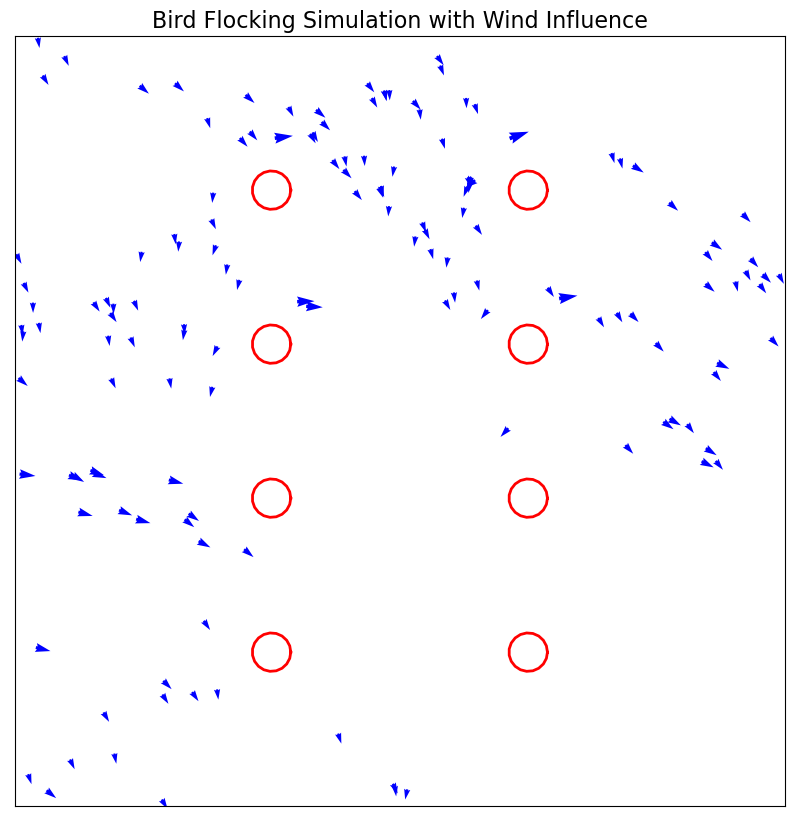

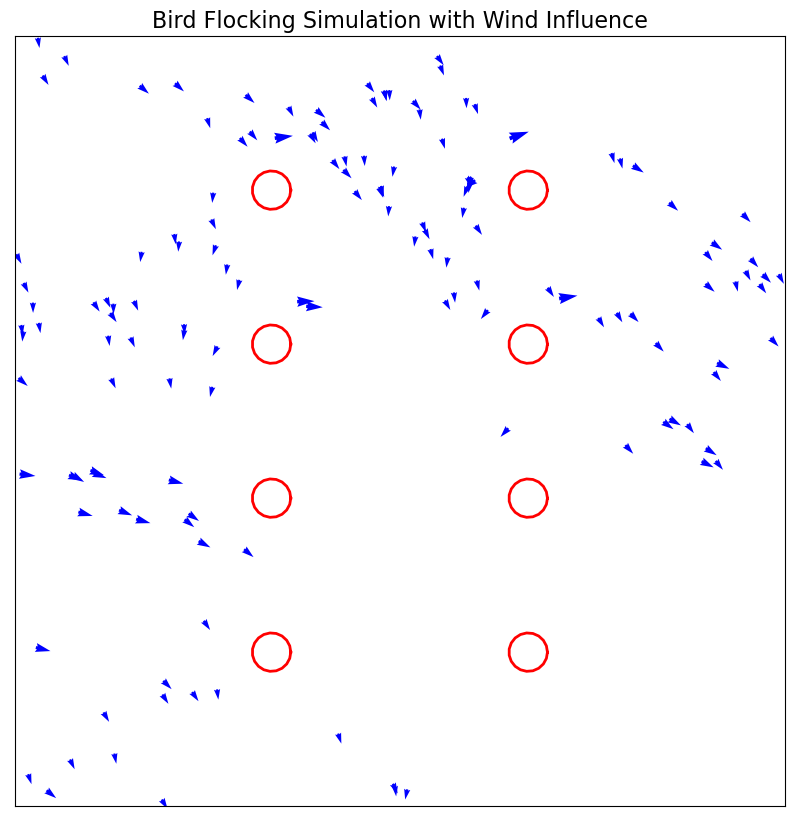

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
# Model Parameters
# # Birds
v0 = 1.0      # velocity of birds (constant)
eta = 0.5      # maximum random fluctuation in angle (in radians)
R_bird = 1        # interaction radius (bird-bird)
Rsq = R_bird**2     # square of the interaction radius
N = 144   # number of birds


# # Time parameters
dt = 0.2      # time step
Nt = 80       # number of time steps

# # Area parameters
L = 10       # size of box (Area of a real wind farm)


# # Obstacles
R_obs = 0.5 # interaction radius (bird - obstacles)
fov_angle = np.pi # Field of View of birds


# # Wind
v0_wind = 0.2 # velocity of wind (constant)
v_wind_noise = 0.05 # maximum random fluctuation in wind velocity (in same units as v0_wind)
wind_theta = 0 # wind direction 


#np.random.seed(17)      # set the random number generator seed

# Starting position
def add_noise_theta(theta, eta, N):
    '''
    Update theta with a random amount of noise between -eta/2 and eta/2
    '''
    theta += eta * (np.random.rand(N, 1) - 0.5)
    
    return theta

def initialize_birds_random(N, L, v0):
    '''
    Set initial positions, direction, and velocities 
    '''
    # Bird positions
    x = np.random.rand(N, 1)*L
    y = np.random.rand(N, 1)*L

    # Bird velocities
    theta = 2 * np.pi * np.random.rand(N, 1)
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    return x, y, vx, vy, theta

def initialize_birds_uniform(N, L, v0, theta_start, eta):
    '''
    Set initial positions as a uniform placement starting at the edge of the box.
    Set direction and velocity to be uniform with a small amount of noise 
    '''
    
    # Set bird initial flock as a square
    N_per_side = int(np.sqrt(N))
    
    # Midpoint of area 
    midpoint = L//2
    
    # Define the x locations (start in centre of perimeter)
    half_length = N_per_side // 2
    start = midpoint - half_length
    x_locs = np.arange(start, start + N_per_side)
    
    # Define the y locations (start from bottom)
    y_locs = np.arange(0, N_per_side)
    
    # Define bird starting points
    # Initialise lists
    x = []
    y = []
    
    for x_loc in x_locs:
        for y_loc in y_locs:
            x.append([x_loc])
            y.append([y_loc])
    
    # Turn into numpy arrays
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    
    # Bird Angle
    # Make all birds same starting angle
    theta = np.ones((len(x),1))*theta_start
    
    # Add noise
    theta = add_noise_theta(theta, eta, N)
    
    
    # Bird velocities
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)
    
    
    return x, y, vx, vy, theta


# Obstacles
def make_circular_obstacle(x_centre, y_centre, R, n=20):
    '''
    Returns x,y points defining a circular obstacle
    '''
    angles = np.linspace(0, 2 * np.pi, n)
    
    x = x_centre + R*np.cos(angles)
    y = y_centre + R*np.sin(angles)
    
    return x, y


def make_rectangular_obstacle(x_centre, y_centre, L1, L2, n=25):
    '''
    Returns x,y points defining a rectangular obstacle
    '''
    
    # Number of points per side
    points_per_side = n // 4
    
    # Half lengths for width and height
    l1 = L1 / 2
    l2 = L2 / 2
    
    # Corners of the rectangle
    top_left = [x_centre - l1, y_centre + l2]
    top_right = [x_centre + l1, y_centre + l2]
    bottom_left = [x_centre - l1, y_centre - l2]
    bottom_right = [x_centre + l1, y_centre - l2]
    
    # Initialize lists for x and y points
    x_points = []
    y_points = []
    
    # Generate points along each side
    # Top edge (left to right)
    x_points.extend(np.linspace(top_left[0], top_right[0], points_per_side))
    y_points.extend([top_left[1]] * points_per_side)
    
    # Right edge (top to bottom)
    x_points.extend([top_right[0]] * points_per_side)
    y_points.extend(np.linspace(top_right[1], bottom_right[1], points_per_side))
    
    # Bottom edge (right to left)
    x_points.extend(np.linspace(bottom_right[0], bottom_left[0], points_per_side))
    y_points.extend([bottom_left[1]] * points_per_side)
    
    # Left edge (bottom to top)
    x_points.extend([bottom_left[0]] * points_per_side)
    y_points.extend(np.linspace(bottom_left[1], top_left[1], points_per_side))
    
    return x_points, y_points

def get_obstacle_centre_grid(L, num_obstacles, nrows, ncols):
    '''
    Define the centre of obstacles based on a grid.
    '''
    x_spacing = L / (ncols + 1)
    y_spacing = L / (nrows + 1)
    
    x_centres = []
    y_centres = []

    # Calc grid positions
    cnt = 0
    for i in range(nrows):
        for j in range(ncols):
            if cnt > num_obstacles:
                break
        
            # Calculate centre positions
            x_centre = (j + 1) * x_spacing
            y_centre = (i + 1) * y_spacing
            x_centres.append(x_centre)
            y_centres.append(y_centre)
            cnt += 1
    
    return x_centres, y_centres

def get_obstacles(L, num_obstacles, nrows, ncols):
    '''
    Call the obstacle functions and get lists of their x, y points
    '''
    
    x_centres, y_centres = get_obstacle_centre_grid(L, num_obstacles, nrows=nrows, ncols=ncols)
    
    # Initalise lists
    x_obstacle_list = []
    y_obstacle_list = []
    
    for i in range(num_obstacles):
        # Make circular obstacles
        x_obs, y_obs = make_circular_obstacle(x_centres[i], y_centres[i], R=0.25, n=20)
        
        # Make rectangular obstacles
        # x_obs, y_obs = make_rectangular_obstacle(x_centres[i], y_centres[i], L1=1, L2=0.2, n=25)
        
        x_obstacle_list.append(x_obs)
        y_obstacle_list.append(y_obs)
    
    # Concatenate lists for analysis
    x_obstacle = np.concatenate(x_obstacle_list)
    y_obstacle = np.concatenate(y_obstacle_list)
    
    return x_obstacle_list, y_obstacle_list, x_obstacle, y_obstacle

# Wind

### Parameters
v0_wind = 0.5 # velocity of wind (constant)
v_wind_noise = 0.1 # maximum random fluctuation in wind velocity (in same units as v0_wind)
wind_theta = 0 # wind direction 


## wind function
def wind_constant_with_noise(v0_wind, v_wind_noise, wind_theta):
    '''
    Returns the x, y components of wind based on a constant angle.
    '''
    # Add random noise to the wind
    v0_wind += v_wind_noise * (np.random.rand(1) - 0.5)[0]

    # Get x, y velocity components
    vx_wind = v0_wind* np.cos(wind_theta)
    vy_wind = v0_wind* np.sin(wind_theta)
    
    return vx_wind, vy_wind


def wind_dynamic(t, v0_wind_base, v_wind_amplitude, v_wind_noise, wind_theta_base, wind_theta_variation, frequency_speed, frequency_direction):
    """
    Simulate wind velocity with a sinusoidal component and noise.
    Args:
        t: Current time step
        v0_wind_base: Base wind speed
        v_wind_amplitude: Amplitude of the sinusoidal variation in wind speed
        v_wind_noise: Maximum random fluctuation in wind speed
        wind_theta_base: Base wind direction (in radians)
        wind_theta_variation: Maximum variation in wind direction
        frequency_speed: Frequency of the sinusoidal wind speed variation
        frequency_direction: Frequency of the sinusoidal wind direction variation
    """
    # Sinusoidal variation in wind speed
    v0_wind = v0_wind_base + v_wind_amplitude * np.sin(2 * np.pi * frequency_speed * t)
    
    # Add random noise to the wind speed
    v0_wind += v_wind_noise * (np.random.rand() - 0.5)
    
    # Gradually change wind direction with sinusoidal variation
    wind_theta = wind_theta_base + wind_theta_variation * np.sin(2 * np.pi * frequency_direction * t)
    
    # Get x, y velocity components of wind
    vx_wind = v0_wind * np.cos(wind_theta)
    vy_wind = v0_wind * np.sin(wind_theta)
    
    return vx_wind, vy_wind


# updating step

def apply_boundary_conditions(x, y, L):
    '''
    Apply periodic boundary conditions
    Creates wrap-around effect, if crossing bounary enter other side 
    '''
    x = x % L
    y = y % L
    return x, y

def update_positions(x, y, vx, vy, dt, L):
    '''
    Update the positions moving dt in the direction of the velocity
    and applying the boundary conditions
    '''
    
    # update positions
    x += vx*dt
    y += vy*dt
    
    # apply boundary conditions
    x, y = apply_boundary_conditions(x,y,L)
    return x, y


#update angle
def get_mean_theta_neighbours(x, y, theta, Rsq, N):
    '''
    Compute the local average direction in a circle of radius R around
    each bird. If there are no neighbours, simply keep same theta.
    '''
    mean_theta = theta
    for bird in range(N):
        neighbours = (x-x[bird])**2+(y-y[bird])**2 < Rsq
        sum_x = np.sum(np.cos(theta[neighbours]))
        sum_y = np.sum(np.sin(theta[neighbours]))
        mean_theta[bird] = np.arctan2(sum_y, sum_x)
    
    return mean_theta

def get_obstacles_within_radius(x_bird, y_bird, theta_bird, x_obstacle, y_obstacle, R_obs, fov_angle):
    
    # Determine if obstacle is in radius
    distances_to_obstacles = np.sqrt((x_obstacle - x_bird) ** 2 + (y_obstacle - y_bird)**2)
    is_in_radius = distances_to_obstacles <= R_obs
    
    # Select only object in radius
    x_obs_in_radius = x_obstacle[is_in_radius]
    y_obs_in_radius = y_obstacle[is_in_radius]
    distances = distances_to_obstacles[is_in_radius]
    
    # Determine if obstacle is in FOV
    
    # Calculate angle to the obstacle    
    delta_x = x_obs_in_radius - x_bird
    delta_y = y_obs_in_radius - y_bird
    angles_to_obstacles = np.arctan2(delta_y, delta_x)
    
    # Difference between obstacle and current direction of bird
    angle_diff = np.abs(angles_to_obstacles - theta_bird)
    
    # Filter by field of view
    is_in_fov = angle_diff <= fov_angle
    x_obs_in_radius = x_obs_in_radius[is_in_fov]
    y_obs_in_radius = y_obs_in_radius[is_in_fov]
    distances = distances[is_in_fov]
    
    return x_obs_in_radius, y_obs_in_radius, distances


def update_theta(x, y, theta, Rsq, x_obstacle, y_obstacle, R_obs, eta, N, fov_angle):
    '''
    We will do this per bird, since we need to see if each one is within distance of obstacles or not
    
    '''
    # Initialize new theta array
    theta_new = theta.copy()
    
    # Get the mean theta from the neighbours
    mean_theta = get_mean_theta_neighbours(x, y, theta, Rsq, N)
    
    # Update theta based on obstacles
    for i in range(N):
        # Determine if obstacles in radius
        x_obs_in_radius, y_obs_in_radius, distances = get_obstacles_within_radius(x[i], y[i], theta_new[i], x_obstacle, y_obstacle, R_obs, fov_angle)

        # Only continue if there are obstacles in radius
        if np.any(distances):
            # Obstacle avoidance logic in advance, gradually adjusting direction
            avoidance_vectors = np.array([x[i] - x_obs_in_radius, y[i] - y_obs_in_radius])
    
            # Normalise by distance (closer obstacles have more influence)
            avoidance_vectors = avoidance_vectors / distances
    
            # Sum up the avoidance vectors to get the net avoidance direction
            net_avoidance_vector = np.sum(avoidance_vectors, axis=0)
    
            #Avoidance strategy: gradually adjust direction instead of direct opposite
            if net_avoidance_vector.size >= 2:
                # Normalize the net avoidance vector to limit abrupt changes
                net_avoidance_vector /= np.linalg.norm(net_avoidance_vector)
                # Combine with current velocity to smoothly adjust direction
                avoidance_theta = np.arctan2(net_avoidance_vector[1], net_avoidance_vector[0])
                avoidance_weight = 0.5  # Reduce weight for smoother turn
                theta_new[i] = (1 - avoidance_weight) * mean_theta[i] + avoidance_weight * avoidance_theta
            else:
                # Use mean direction if no valid avoidance vector found
                theta_new[i] = mean_theta[i]

        
        # If no obstacle, use theta from neighbours
        else:
            theta_new[i] = mean_theta[i]
        
    
    theta_new = add_noise_theta(theta_new, eta, N)
    
    return theta_new

#update velocity
def update_velocities(v0, theta, vx_wind, vy_wind):
    '''
    Update the velocities given theta, assuming a constant speed v0
    '''
    vx = v0 * np.cos(theta) + vx_wind
    vy = v0 * np.sin(theta) + vy_wind

    return vx, vy

#Quiver
def step(x, y, vx, vy, theta, Rsq, x_obstacle, y_obstacle, eta, fov_angle, N, dt, v0_wind, v_wind_noise, wind_theta):
    '''
    Compute a step in the dynamics:
    - update the positions
    - compute the new velocities
    '''
    x, y = update_positions(x, y, vx, vy, dt, L)
    theta = update_theta(x, y, theta, Rsq, x_obstacle, y_obstacle, R_obs, eta, N, fov_angle)
    
    vx_wind, vy_wind = wind_constant_with_noise(v0_wind, v_wind_noise, wind_theta)
    
    vx, vy = update_velocities(v0, theta, vx_wind, vy_wind)
    
    return x, y, vx, vy, vx_wind, vy_wind

def update_quiver(q,x,y,vx,vy):
    '''
    Update a quiver with new position and velocity information
    This is only used for plotting
    '''
    q.set_offsets(np.column_stack([x,y]))
    q.set_UVC(vx,vy)
    
    return q


def get_clustering_coefficient(vx, vy, v0, vx_wind, vy_wind, N):
    
    # Sum the vx and vy components (with wind included)
    sum_terms_x = np.sum(vx)
    sum_terms_y = np.sum(vy)
    sum_terms = np.linalg.norm([sum_terms_x, sum_terms_y])
    
    # Get the expected v, v0 + v_wind
    # Expected total velocity magnitude per bird
    # v_expected = np.sqrt(v0**2 + vx_wind**2 + vy_wind**2) # doesn't work?
    
    # Average bird speed (calculate direc)
    v_expected = np.mean(np.sqrt(vx**2 + vy**2))
    
    # Calculate coefficient
    clustering_coefficient = (1/(N*v_expected))*sum_terms
    
    return clustering_coefficient


# Set up a figure
fig, ax = plt.subplots(figsize=(10, 10))

# Get obstacles
# Number of obstacles
num_obstacles = 8
nrows = 4
ncols = 2

x_obstacle_list, y_obstacle_list, x_obstacle, y_obstacle = get_obstacles(L, num_obstacles, nrows, ncols)

# Plot obstacles - Plot the "list" to visualize the different obstacles properly
for xx, yy in zip(x_obstacle_list, y_obstacle_list):
    ax.plot(xx, yy, 'r-', linewidth=2)

# Get the initial configuration

# Random
# x, y, vx, vy, theta = initialize_birds_random(N, L, v0)

# Uniform
theta_start = np.pi / 3
x, y, vx, vy, theta = initialize_birds_uniform(N, L, v0, theta_start, eta)

# Plot initial quivers
q = plt.quiver(x, y, vx, vy, scale=40)

# Set figure parameters
ax.set(xlim=(0, L), ylim=(0, L))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Initialize lists to plot later
vx_wind_list = []
vy_wind_list = []

clustering_coefficients = []

# Wind parameters
v0_wind_base = 0.2  # Base wind speed
v_wind_amplitude = 0.1  # Wind speed amplitude

frequency_speed = 0.05  # Frequency of wind speed variation
frequency_direction = 0.01  # Frequency of wind direction variation
wind_theta_base = 0  # Base wind direction (along x-axis)
wind_theta_variation = np.pi / 4  # Maximum variation in wind direction angle

# Perform each step, updating the quiver and plotting the new one
for t in range(Nt):
    # Calculate wind components with dynamic wind model
    vx_wind, vy_wind = wind_dynamic(t * dt, v0_wind_base, v_wind_amplitude, v_wind_noise, wind_theta_base, wind_theta_variation, frequency_speed, frequency_direction)

    # Update bird positions and velocities
    for _ in range(2):  # Adjust directions multiple times within each time step
        theta = update_theta(x, y, theta, Rsq, x_obstacle, y_obstacle, R_obs, eta, N, fov_angle)

    x, y, vx, vy, _, _ = step(x, y, vx, vy, theta, Rsq, x_obstacle, y_obstacle, eta, fov_angle, N, dt, v0_wind, v_wind_noise, wind_theta=np.pi / 2)

    # Plot updated quiver with fixed scale
    ax.clear()
    ax.set_title('Bird Flocking Simulation with Wind Influence', fontsize=16)
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    for xx, yy in zip(x_obstacle_list, y_obstacle_list):
        ax.plot(xx, yy, 'r-', linewidth=2)

    q = plt.quiver(x, y, vx, vy, scale=4, angles='xy', scale_units='xy', color='b', width=0.005)

    clear_output(wait=True)
    display(fig)

    # Append wind information
    vx_wind_list.append(vx_wind)
    vy_wind_list.append(vy_wind)

    # Append clustering coefficient
    clustering_coefficients.append(get_clustering_coefficient(vx, vy, v0, vx_wind, vy_wind, N))

plt.ioff()
plt.show()


